In [1]:
from opera_utils.disp import DispProductStack, open_h5, search

%load_ext rich

In [2]:
granules = search.get_products(9154)
granules[:2]


[
    Granule(
        product=DispProduct(
            filename='https://datapool.asf.alaska.edu/DISP/OPERA-S1/OPERA_L3_DISP-S1_IW_F09154_VV_20160705T020626Z_20170125T020626Z_v1.0_20250408T162732Z.nc',
            sensor='S1',
            acquisition_mode='IW',
            frame_id=9154,
            polarization='VV',
            reference_datetime=datetime.datetime(2016, 7, 5, 2, 6, 26, tzinfo=datetime.timezone.utc),
            secondary_datetime=datetime.datetime(2017, 1, 25, 2, 6, 26, tzinfo=datetime.timezone.utc),
            version='1.0',
            generation_datetime=datetime.datetime(2025, 4, 8, 16, 27, 32, tzinfo=datetime.timezone.utc)
        ),
        url='https://datapool.asf.alaska.edu/DISP/OPERA-S1/OPERA_L3_DISP-S1_IW_F09154_VV_20160705T020626Z_20170125T020626Z_v1.0_20250408T162732Z.nc',
        orbit_pass=<OrbitPass.ASCENDING: 'ASCENDING'>
    ),
    Granule(
        product=DispProduct(
            filename='https://datapool.asf.alaska.edu/DISP/OPERA-S1/OPERA_L3_D

In [27]:
# open_h5?
stack = DispProductStack(
    sorted([g.product for g in granules], key=lambda g: g.secondary_datetime)
)
stack[:3]


[
    DispProduct(
        filename='https://datapool.asf.alaska.edu/DISP/OPERA-S1/OPERA_L3_DISP-S1_IW_F09154_VV_20160705T020626Z_20160717T020626Z_v1.0_20250408T162732Z.nc',
        sensor='S1',
        acquisition_mode='IW',
        frame_id=9154,
        polarization='VV',
        reference_datetime=datetime.datetime(2016, 7, 5, 2, 6, 26, tzinfo=datetime.timezone.utc),
        secondary_datetime=datetime.datetime(2016, 7, 17, 2, 6, 26, tzinfo=datetime.timezone.utc),
        version='1.0',
        generation_datetime=datetime.datetime(2025, 4, 8, 16, 27, 32, tzinfo=datetime.timezone.utc)
    ),
    DispProduct(
        filename='https://datapool.asf.alaska.edu/DISP/OPERA-S1/OPERA_L3_DISP-S1_IW_F09154_VV_20160705T020626Z_20160729T020627Z_v1.0_20250408T162732Z.nc',
        sensor='S1',
        acquisition_mode='IW',
        frame_id=9154,
        polarization='VV',
        reference_datetime=datetime.datetime(2016, 7, 5, 2, 6, 26, tzinfo=datetime.timezone.utc),
        secondary_dateti

In [28]:
stack.shape

(299, 7980, 9593)

In [30]:
stack.get_rasterio_profile()["transform"]


Affine(30.0, 0.0, 483510.0,
       0.0, -30.0, 3903570.0)

In [29]:
# %%time

# open_h5(stack[0])

In [6]:
from shapely import wkt

point = wkt.loads("POINT(-120.31498942420649 34.026542674879764)")


Affine(30.0, 0.0, 483510.0,
       0.0, -30.0, 3903570.0)

In [32]:
from opera_utils.disp import _remote

In [42]:
lons = slice(-120.45, -120.3)
lats = slice(34.07, 34.01)

In [43]:
np.array(34.2).size

1

In [56]:
%%time

disp_chunk = _remote.process_stack(stack, lons, lats, 15, dset="displacement")

Reading products: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 299/299 [02:00<00:00,  2.48it/s]

CPU times: user 349 ms, sys: 352 ms, total: 701 ms
Wall time: 2min


In [47]:
%time p2 = _remote.process_stack(stack, lons, lats, 15, dset='short_wavelength_displacement')

Reading products: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 299/299 [01:59<00:00,  2.50it/s]

CPU times: user 312 ms, sys: 288 ms, total: 601 ms
Wall time: 1min 59s


In [51]:
ss = (pA @ p2.reshape(len(p2), -1)).reshape(p2.shape)

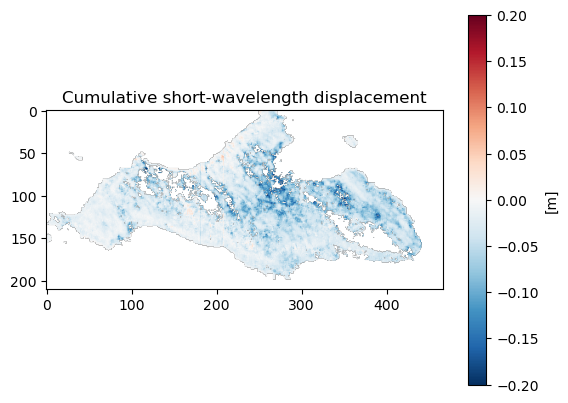

In [61]:
fig, ax = plt.subplots()
axim = ax.imshow(ss[-1], vmax=0.2, vmin=-0.2, cmap="RdBu_r")
ax.set_title("Cumulative short-wavelength displacement")
fig.colorbar(axim, label='[m]')

In [58]:
disp_chunk_reffed = disp_chunk - disp_chunk[:, 120, 80][:, None, None]

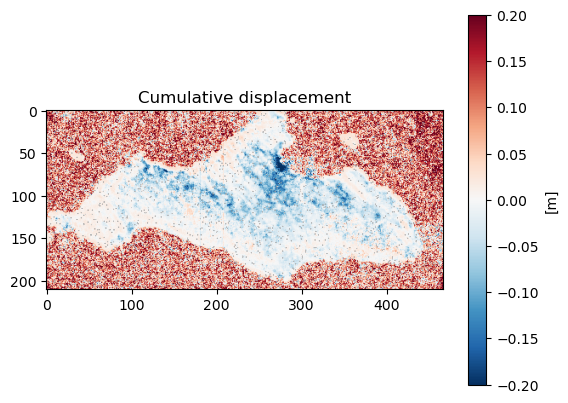

In [62]:
dc = (pA @ disp_chunk_reffed.reshape(len(disp_chunk), -1)).reshape(disp_chunk.shape)

fig, ax = plt.subplots()
axim = ax.imshow(dc[-1], vmax=0.2, vmin=-0.2, cmap="RdBu_r")
ax.set_title("Cumulative displacement")
fig.colorbar(axim, label='[m]')

In [39]:
from dolphin import timeseries

pA = np.linalg.pinv(timeseries.get_incidence_matrix(stack.ifg_date_pairs))

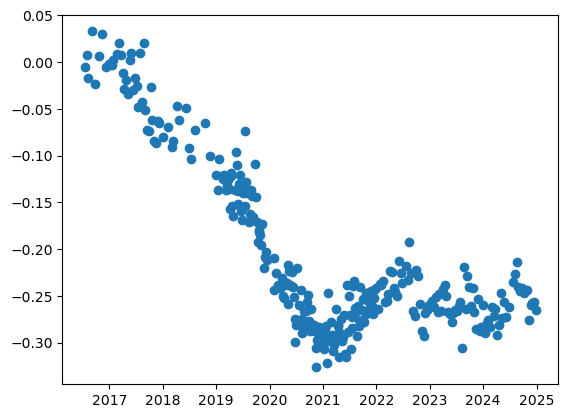

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(stack.secondary_dates, pA @ np.squeeze(results))